# DC1d modelling and inversion
We want to use direct-current (DC) modelling for 1D layered Earth models.
This is readily implemented in the pyGIMLi (Python Geophysical Modelling and Inversion module).
We make use of the `PyCall` library to call the codes from Julia.

In [1]:
using PyCall
using PyPlot

In [2]:
pg=pyimport("pygimli")

PyObject <module 'pygimli' from 'C:\\Guenther.T\\src\\gimli\\gimli\\pygimli\\__init__.py'>

In [4]:
pos=pg.Pos([1, 1, 0])
mesh=pg.createGrid(5,5)
print(mesh)

PyObject <pygimli.core._pygimli_.Mesh object at 0x000000003F8200F0>

In [5]:
# We define a AB/2 vector going from 1 to 1000m
ab2 = 10 .^ (0:0.1:3);

In [8]:
# Now we define a 1D DC forward operator, for MN/2 we use AB/2 / 3
number_of_layers = 3
f = pg.core.DC1dModelling(number_of_layers, ab2, ab2/3);

In [9]:
rhoa = f([5, 5, 100, 20, 100]).array();  # two thicknesses, three resistivities

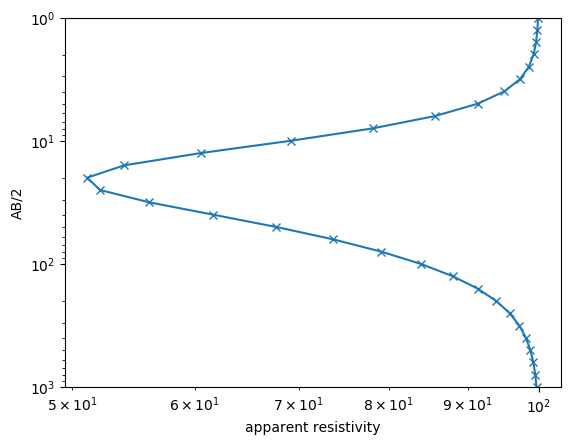

In [10]:
loglog(rhoa, ab2, "x-")
ylim(ab2[end], ab2[1])
xlabel("apparent resistivity")
ylabel("AB/2");

Whereas `DC1dModelling` gets thickness and resistivity values, there is a variant `DC1dRhoModelling` for only resistivity using a predefined thickness vector. This is made for smoothness-constrained inversion.

In [100]:
thkFix = ones(30)
fRho = pg.core.DC1dRhoModelling(thkFix, ab2, ab2/3);

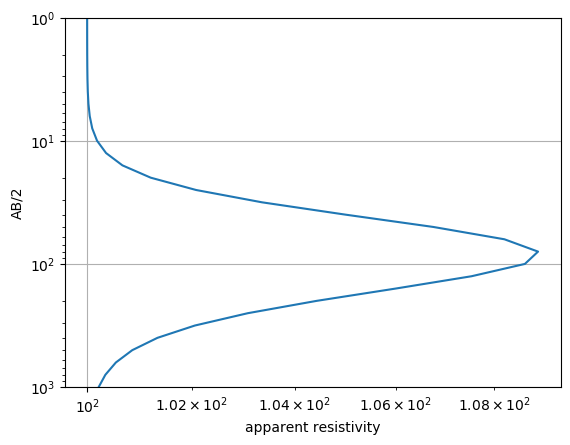

In [14]:
rho = ones(length(thk)+1) * 100
rho[end-2] = 1000
rhoa = fRho(rho).array()
loglog(rhoa, ab2)
grid()
ylim(ab2[end], ab2[1])
xlabel("apparent resistivity")
ylabel("AB/2");

Install the PyCall by calling
```
using Pkg
Pkg.add("PyCall")
```
Make sure pyGIMLi is installed by calling on the Anaconda command line
```
conda install -c gimli -c conda-forge pygimli=1.1
```

## Task
1. Write a Julia function using the variable-layer forward operator 
1. Write a Julia function using the fixed-layer forward operator 
1. generate a synthetic three-layer model and compute its forward response
1. write a function for computing the Jacobian matrix using the perturbation method
$$ \frac{\partial {\bf f}({\bf m})}{\partial m_j} \approx
\frac{{\bf f}({\bf m} + \delta_j\Delta m )-{\bf f}({\bf m})}{\Delta m} $$
1. Start with a homogeneous resistivity model.
1. compute its Jacobian matrix and display it using matshow

In [40]:
# some function definitions
dc1dblock(model) = f(model).array();
dc1dblock(rho, thk) = dc1dblock(vcat(thk, rho))
dc1dsmooth(model) = fRho(model).array();
function showSounding(rhoa)
    loglog(rhoa, ab2, "x-")
    ylim(maximum(ab2), minimum(ab2));
    grid()
    xlabel("apparent resistivity")
    ylabel("AB/2");
end;

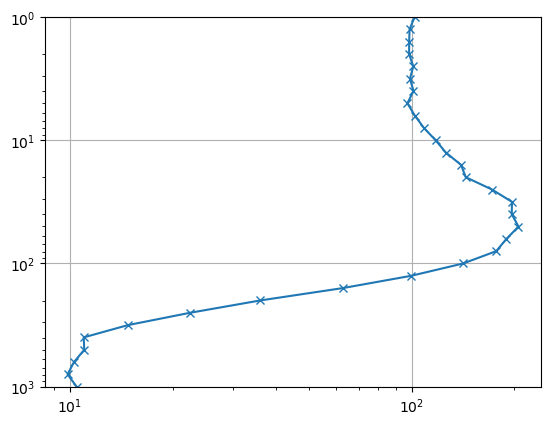

In [41]:
rho = [100, 1000, 10]  # resistivity vector
thk = [10, 10]
data = dc1dblock(rho, thk)
data = data .* (randn(size(data)) * 0.03 .+ 1.0)
showSounding(data)

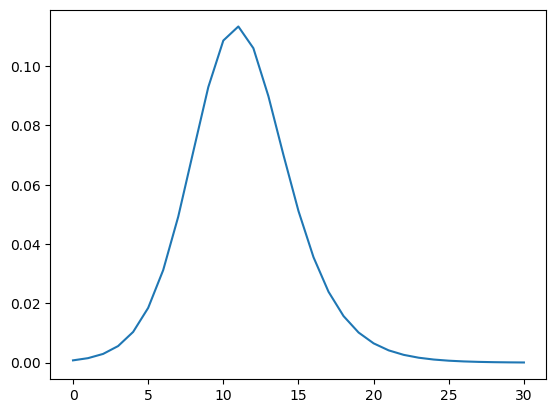

In [89]:
resistivity = ones(30) * 100
fm = dc1dsmooth(resistivity)
resistivity1 = resistivity * 1.0 # make a copy!
i = 5
resistivity1[i] *= 1.1  # change by 10%
fm1 = dc1dsmooth(resistivity1)
sens = (fm1 - fm) ./ (resistivity1[i] - resistivity[i])
plot(sens);

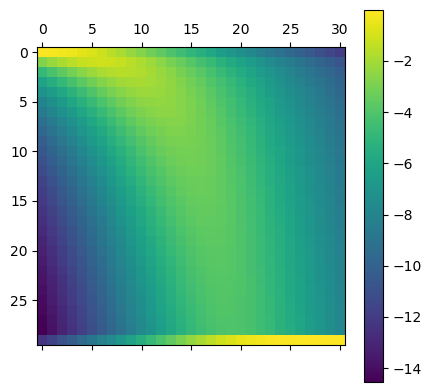

In [90]:
# Now do it for all layers
numlay = fRho.mesh().cellCount()
resistivity = ones(numlay) * 100
fm = dc1dsmooth(resistivity)
S = zeros(length(fm), length(resistivity))
for i = 1:numlay
    resistivity1 = resistivity * 1.0 # make a copy!
    resistivity1[i] *= 1.1  # change by 10%
    fm1 = dc1dsmooth(resistivity1)
    S[:, i] = (fm1 - fm) ./ (resistivity1[i] - resistivity[i])
end
matshow(transpose(log.(S)));
colorbar();

In [ ]:
function DC1dSens(resistivity)
    fm = dc1dsmooth(resistivity)
    S = zeros(length(fm), length(resistivity))
    for i = 1:numlay
        resistivity1 = resistivity * 1.0 # make a copy!
        resistivity1[i] *= 1.1  # change by 10%
        fm1 = dc1dsmooth(resistivity1)
        S[:, i] = (fm1 - fm) ./ (resistivity1[i] - resistivity[i])
    end
    return S
end
    
numlay = fRho.mesh().cellCount()
resistivity = ones(numlay) * 100
S = DC1dSens(resistivity)
matshow(transpose(log.(S)));
colorbar();

## Task 2:
Generate a three-layer model of which the first and last resistivity model and the thickness of the first layer is assumed constant. Vary the second layer resistivity and thickness over a certain range and plot the resulting objective function $\|d-f(m)\|$  as a matrix.

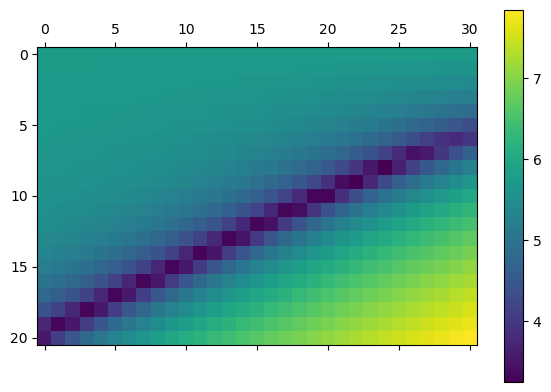

In [91]:
using LinearAlgebra
rho = [100.0, 1000.0, 100.0]  # resistivity vector (resistive anomaly)
thk = [10.0, 10.0]
data = dc1dblock(rho, thk)
data = data .* (randn(size(data)) * 0.03 .+ 1.0)
rhovals = 10 .^ (2:0.1:4)
thkvals = 10 .^ (0:0.05:1.5)
Phi = zeros(length(rhovals), length(thkvals))
for i = 1:length(rhovals)
    for j = 1:length(thkvals)
        rho[2] = rhovals[i]
        thk[2] = thkvals[j]
        fm = dc1dblock(rho, thk)
        Phi[i, j] = norm(data-fm)
    end
end
matshow(log.(Phi))
colorbar();

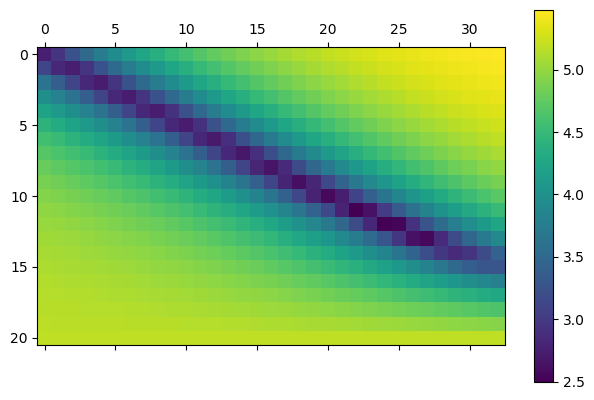

In [79]:
using LinearAlgebra
rho = [100.0, 10.0, 100.0]  # resistivity vector (conductive anomaly)
thk = [10.0, 10.0]
data = dc1dblock(rho, thk)
data = data .* (randn(size(data)) * 0.03 .+ 1.0)
rhovals = 10 .^ (0:0.1:2)
thkvals = 10 .^ (0:0.05:1.6)
Phi = zeros(length(rhovals), length(thkvals))
for i = 1:length(rhovals)
    for j = 1:length(thkvals)
        rho[2] = rhovals[i]
        thk[2] = thkvals[j]
        fm = dc1dblock(rho, thk)
        Phi[i, j] = norm(data-fm)
    end
end
matshow(log.(Phi))
colorbar();

## Do a smoothness-constrained inversion
Tasks
1. Use the sensitivity matrix to compute a new model by Gauss-Newton
2. Use smoothness constraints for regularization
1. Use a line search procedure to determine the step length
1. Optimize the regularization parameter to fit the data within noise
3. Repeat the same with logarithmic model parameters

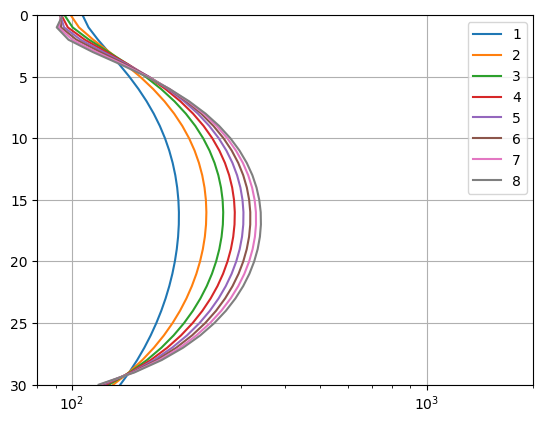

In [152]:
z = cumsum(vcat(0, thkFix))
model = ones(length(z)) * 100
C = zeros(length(thkFix), length(thkFix) + 1)
for i = 1:length(thkFix),
    C[i, i] = -1
    C[i, i+1] = +1
end
lambda = 10
for i = 1:8
    fm = dc1dsmooth(model)
    S = DC1dSens(model)
    ST = transpose(S) 
    deltaModel = inv(ST * S .+ transpose(C) * C * lambda) * (ST * (data .- fm))
    model = model + deltaModel
    semilogx(model, z, label=string(i))
end
ylim(maximum(z), minimum(z))
xlim(80, 2000)
grid();
legend();

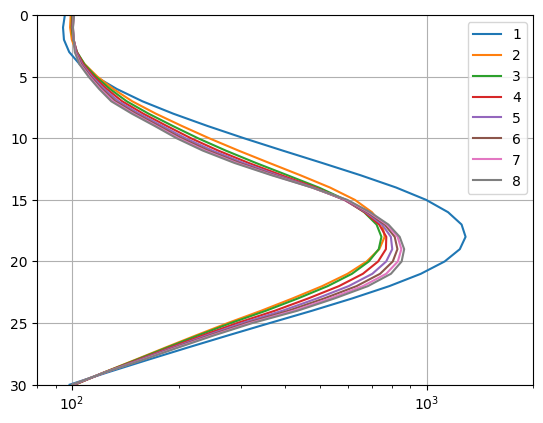

In [166]:
# The same with logarithmic model parameters
model = ones(length(z)) * 100
C = zeros(length(thkFix), length(thkFix) + 1)
for i = 1:length(thkFix),
    C[i, i] = -1
    C[i, i+1] = +1
end
lambda = 10
for i = 1:8
    fm = dc1dsmooth(model)
    S = DC1dSens(model)
    Slog = Diagonal(1.0 ./ fm) * S * Diagonal(model)
    deltaData = (log.(data) .- log.(fm))
    ST = transpose(Slog)
    CTC = transpose(C) * C
#    deltaModel = inv(ST * Slog .+ CTC * lambda) * (ST * deltaData) .- CTC * log.(model) .* lambda
    deltaModel = inv(ST * Slog .+ CTC * lambda) * deltaData
    model = model .* exp.(deltaModel)
    semilogx(model, z, label=string(i))
end
ylim(maximum(z), minimum(z))
xlim(80, 2000)
grid();
legend();

## Block inversion
Task:
1. Perform a block inversion, i.e. using thickness and resistivity values
1. Try without regularization, and use damping constraints for regularization
1. Use different starting models and show the course of the inversion on top of the objective function for the second-layer thickness and resistiviy
1. Increase the noise level
1. Repeat the same with four layers